# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile

plt.rcdefaults()

# Loading Data

## Downloading Data

In [2]:
!kaggle competitions download -c sa2022


  0%|          | 0.00/675k [00:00<?, ?B/s]
100%|██████████| 675k/675k [00:01<00:00, 401kB/s]
100%|██████████| 675k/675k [00:01<00:00, 401kB/s]


## Extracting Data

In [3]:
with open('sa2022.zip', 'rb') as f:
    z = zipfile.ZipFile(f)
    z.extractall("data")
    z.close()

## The Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Preliminary Analysis

In [5]:
train.head()

,id,title,Rating,maincateg,platform,price1,actprice1,Offer %,norating1,noreviews1,star_5f,star_4f,star_3f,star_2f,star_1f,fulfilled1
0,16695,Fashionable & Comfortable Bellies For Women (...,3.9,Women,Flipkart,698,999,30.13%,38.0,7.0,17.0,9.0,6.0,3,3,0
1,5120,Combo Pack of 4 Casual Shoes Sneakers For Men ...,3.8,Men,Flipkart,999,1999,50.03%,531.0,69.0,264.0,92.0,73.0,29,73,1
2,18391,Cilia Mode Leo Sneakers For Women (White),4.4,Women,Flipkart,2749,4999,45.01%,17.0,4.0,11.0,3.0,2.0,1,0,1
3,495,Men Black Sports Sandal,4.2,Men,Flipkart,518,724,15.85%,46413.0,6229.0,1045.0,12416.0,5352.0,701,4595,1
4,16408,Men Green Sports Sandal,3.9,Men,Flipkart,1379,2299,40.02%,77.0,3.0,35.0,21.0,7.0,7,7,1


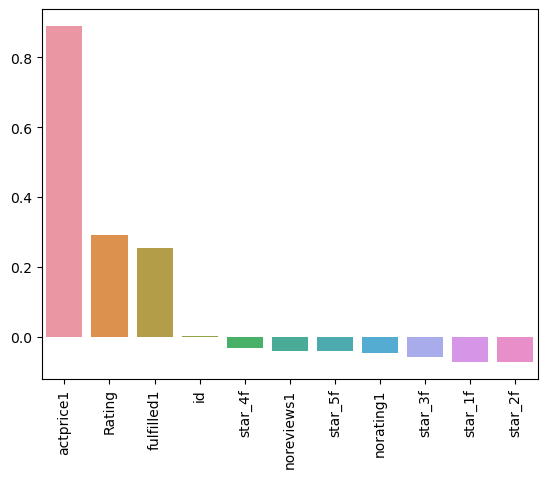

In [18]:
corr = train.corr()["price1"].sort_values(ascending=False)[1:]
sns.barplot(y=corr.values, x=corr.index)
plt.xticks(rotation=90);

In [19]:
train.isna().sum()

id              0
title           0
Rating          0
maincateg     526
platform        0
price1          0
actprice1       0
Offer %         0
norating1     678
noreviews1    578
star_5f       588
star_4f       539
star_3f       231
star_2f         0
star_1f         0
fulfilled1      0
dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [86]:

class FeatureImputor:
    def __init__(self, df, features=None, max_unique_to_drop=15):
        self.df = self._read_data(df)

        self.features = features
        self.length = len(self.df)
        self.max_unique_to_drop = max_unique_to_drop
        self.all_features = self.df.columns
        if features is None:
            self.features = self.all_features
        self._some_details()
        self.model = None
        self.le = LabelEncoder()
    def _read_data(self, df):
        if isinstance(df, str):
            return pd.read_csv(df)
        elif isinstance(df, pd.DataFrame):
            return df

    def _some_details(self):
        num_unique_values = {}
        missing_values = {}
        for feature in self.all_features:
            num_unique_values[feature] = self.df[feature].nunique()
            missing_values[feature] = self.df[feature].isna().sum()
        self.num_unique_values = num_unique_values
        self.missing_values = missing_values
        self.col_dtypes = self.df.dtypes

    def _drop_features(self, col):
        cols_to_drop = [col]
        max_unique = self.max_unique_to_drop
        for column in self.all_features:
            col_is_object = self.col_dtypes[column] == "object"
            if (self.num_unique_values[column] > max_unique) and col_is_object:
                cols_to_drop.append(column)
        return cols_to_drop

    def _create_train_pred_dataset(self, col):
        cols_to_drop = self._drop_features(col)
        original_target = self.df[col]
        df_to_train = self.df[self.df[col].notna()]
        df_to_predict = self.df[self.df[col].isna()]
        target = df_to_train[col]
       
        df_to_train = df_to_train.drop(cols_to_drop, axis=1)
        df_to_predict = df_to_predict.drop(cols_to_drop, axis=1)
        df_to_predict_index = df_to_predict.index.values
        self.df_to_train = df_to_train
        self.df_to_predict = df_to_predict
        self.df_to_predict_index = df_to_predict_index
        self.target = target
        self.original_target = original_target

    def _create_dummy(self):
        self.df_to_train = pd.get_dummies(self.df_to_train, drop_first=True)
        self.df_to_predict = pd.get_dummies(self.df_to_predict, drop_first=True)

    def _label_target(self, target):
        if self.col_dtypes[target]=="object":
            self.target = self.le.fit_transform(self.target)
        else:
            self.target = self.target
        # return self.target
    def _check_columns(self):
        train_cols = self.df_to_train.columns
        predict_cols = self.df_to_predict.columns
        # if len(train_cols) != len(predict_cols):
            # print("Colimns Mismatch. Adjusting...")
        if len(train_cols) > len(predict_cols):
            self.df_to_predict = self.df_to_predict.reindex(columns=train_cols)
        elif len(train_cols) < len(predict_cols):
            self.df_to_train = self.df_to_train.reindex(columns=predict_cols)

    def _predict(self, target):
        dtype = self.col_dtypes[target]
        self._check_columns()
        if dtype != "object":
            # print("Using XGBoostRegressor")
            self.model = xgb.XGBRFRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
            decode=False
        else:
            # print("Using XGBoostClassifier")
            self.model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
            decode=True

        self.model.fit(self.df_to_train, self.target)
        # print("Fitted!")
        preds = self.model.predict(self.df_to_predict)
        if decode:
            preds = self.le.inverse_transform(preds)
        self.preds = preds
        return preds

    def _fill_missing_values(self, col):
        original_target_copy = self.original_target.copy()
        original_target_copy.iloc[self.df_to_predict_index] = self.preds
        self.df[col] = original_target_copy
        return self.df
    
    def _impute_one(self, col):
        print(f"Filling {self.missing_values[col]} missing values in {col}!")
        self._create_train_pred_dataset(col=col)
        # print("Creating dummy variables")
        self._create_dummy()
        # print("Labeling target")
        self._label_target(col)
        # print("Predicting")
        self._predict(col)
        # print("Filling missing values")
        self._fill_missing_values(col)
        
        return self.df
    
    def impute(self, file_path = ""):
        cols = self.features
        for col in cols:
            if self.missing_values[col] <= 0:
                continue
            if (self.max_unique_to_drop < self.num_unique_values[col]) and (self.col_dtypes[col] == "object"):
                print("Column: ", col, " has too many unique values. Skipping...")
                continue
            self.df = self._impute_one(col)
        if file_path:
            self.df.to_csv(file_path, index=False)
        return self.df

In [102]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train_without_target = train.drop(["price1"], axis=1)

In [103]:
imputor = FeatureImputor(train_without_target)
df2 = imputor.impute()

Filling 526 missing values in maincateg!
Filling 678 missing values in norating1!
Filling 578 missing values in noreviews1!
Filling 588 missing values in star_5f!
Filling 539 missing values in star_4f!
Filling 231 missing values in star_3f!


In [104]:
df2 = pd.concat([df2, train["price1"]], axis=1)

In [105]:
df2.isna().sum()

id            0
title         0
Rating        0
maincateg     0
platform      0
actprice1     0
Offer %       0
norating1     0
noreviews1    0
star_5f       0
star_4f       0
star_3f       0
star_2f       0
star_1f       0
fulfilled1    0
price1        0
dtype: int64

In [106]:
df2.to_csv("data/train_imputed.csv", index=False)

In [96]:
imputor = FeatureImputor('data/test.csv')
df2 = imputor.impute("data/test_imputed.csv")

Filling 203 missing values in Rating!
Filling 67 missing values in maincateg!
Filling 68 missing values in star_5f!
Filling 186 missing values in star_1f!


In [97]:
df2.isna().sum()

id            0
title         0
Rating        0
maincateg     0
platform      0
actprice1     0
norating1     0
noreviews1    0
star_5f       0
star_4f       0
star_3f       0
star_2f       0
star_1f       0
fulfilled1    0
dtype: int64

In [107]:
train = pd.read_csv('data/train_imputed.csv')
test = pd.read_csv('data/test_imputed.csv')

In [108]:
train.drop(['id', "title", "Offer %"], axis=1, inplace=True)
test.drop(['id', "title"], axis=1, inplace=True)

In [109]:
X = train.drop(['price1'], axis=1)
y = train['price1']
X.shape, test.shape

((15730, 12), (5244, 12))

In [110]:
X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)
X.shape, test.shape

((15730, 12), (5244, 12))

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [113]:
test_scaled = scaler.transform(test)

In [131]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)
print(mean_squared_error(y_test, preds))
print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

84146.30519254353
182.2403649085791
0.8179918042876293


In [133]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=42)
rfr.fit(X_train, y_train)

preds = rfr.predict(X_test)
print(mean_squared_error(y_test, preds))
print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

73382.43934039793
170.3328466567939
0.8412740125575726


In [120]:
xgbr = xgb.XGBRegressor(n_estimators=1000, max_depth=4, learning_rate=0.1)
xgbr.fit(X_train, y_train)

xgbr.score(X_test, y_test)

0.9039489969252691

In [121]:
xgbr.score(X_train, y_train)

0.9669379109666469

In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [122]:
preds = xgbr.predict(X_test)
print(mean_squared_error(y_test, preds))
print(mean_absolute_error(y_test, preds))
print(r2_score(y_test, preds))

44406.44547429521
117.25347308178881
0.9039489969252691


In [123]:
print(mean_absolute_error(y_train, xgbr.predict(X_train)))

79.28093137577395


In [124]:
preds

array([ 374.5779 ,  879.3755 , 1461.501  , ...,  459.21808,  314.34637,
       3018.8853 ], dtype=float32)

In [134]:
preds_final = rfr.predict(test_scaled)

In [135]:
sample = pd.read_csv('data/Sample__submission.csv')

In [136]:
sample['price1'] = preds_final

In [137]:
preds_final

array([456.67415322, 299.46654023, 456.67415322, ..., 456.67415322,
       299.42412655, 460.33816381])

In [138]:
sample.to_csv('data/submission.csv', index=False)

In [139]:
!kaggle competitions submit -c sa2022 -f data/submission.csv -m "Base Submission"

Successfully submitted to Final Capstone Project



  0%|          | 0.00/128k [00:00<?, ?B/s]
  6%|▋         | 8.00k/128k [00:00<00:01, 79.0kB/s]
100%|██████████| 128k/128k [00:06<00:00, 19.7kB/s] 
